In [50]:
import numpy as np
from scipy.spatial import distance
from scipy.special import beta
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torchvision import datasets
from sklearn.linear_model import LinearRegression
from matplotlib.backends.backend_pdf import PdfPages

In [31]:
dfs = {}

print('MNIST')
train = datasets.MNIST('./data/mnist/train', train=True, download=True)
test = datasets.MNIST('./data/mnist/test', train=False, download=True)
dfs['MNIST'] = pd.DataFrame({
    'images': \
        [ image for image, label in train ] + [ image for image, label in test ],
    'labels': \
        [ label.item() for image, label in train ] + [ label.item() for image, label in test ],
})

print('CIFAR10')
train = datasets.CIFAR10('./data/mnist/train', train=True, download=True)
test = datasets.CIFAR10('./data/mnist/test', train=False, download=True)
dfs['CIFAR10'] = pd.DataFrame({
    'images': \
        [ image for image, label in train ] + [ image for image, label in test ],
    'labels': \
        [ label for image, label in train ] + [ label for image, label in test ],
})

print('RANDOM15')
size=int(1e5)
# 1M random 1d pictures w/ 10px
data = torch.randn(size, 15)
#data /= data.norm(dim=1).view(-1,1).expand(data.shape)
data /= np.sqrt(15)
dfs['RANDOM15'] = pd.DataFrame({
    'images': data,
    'labels': np.random.randint(2, size=size)
})

print('RANDOM35')
size=int(1e5)
# 1M random 1d pictures w/ 30px
data = torch.randn(size, 35)
#data /= data.norm(dim=1).view(-1,1).expand(data.shape)
data /= np.sqrt(35)
dfs['RANDOM35'] = pd.DataFrame({
    'images': data,
    'labels': np.random.randint(2, size=size)
})

print('RANDOM40')
size=int(1e5)
# 1M random 1d pictures w/ 30px
data = torch.randn(size, 40)
#data /= data.norm(dim=1).view(-1,1).expand(data.shape)
data /= np.sqrt(40)
dfs['RANDOM40'] = pd.DataFrame({
    'images': data,
    'labels': np.random.randint(2, size=size)
})

MNIST
CIFAR10
Files already downloaded and verified
Files already downloaded and verified
RANDOM15
RANDOM35
RANDOM40


In [32]:
#nn_dens = {}

In [33]:
### USING SCIPY'S CDIST

NPS = 50
PMAX = np.inf
NSAMPLESMAX = 1000
PBREAK = 10000

for name, df in dfs.items():
    print("DATASET:", name)

    Ps = [ int(i) for i in np.logspace(1, np.log10(len(df)), NPS) ]
    nn_dens[name] = {}

    for P in Ps:
        #if P >= 10000: break
        print(P, 10*'\t', end='\r')
        if P > len(dfs[name]):
            pass

        Pprime = min(P, NSAMPLESMAX) if P < PBREAK else NSAMPLESMAX*PBREAK//P#P

        x = torch.stack(list(
            dfs[name]['images'].sample(P).map(lambda x: torch.Tensor(np.asarray(x).reshape(-1,))).values
        ))
        xprime = x[np.random.choice(range(P), Pprime, replace=False)]
        d = x.shape[1]
        # dists ~ (P, Pprime): dists[i,j] == |x_i - x_j|, w/ i=1..P and j=j_1..j_Pprime
        dists = distance.cdist(x, xprime)
        dists[dists == 0] = np.inf
        nn_dens[name][P] = dists.min(axis=0)#dists.min()

DATASET: MNIST
DATASET: CIFAR10
DATASET: RANDOM15
DATASET: RANDOM35
DATASET: RANDOM40


In [34]:
del dfs

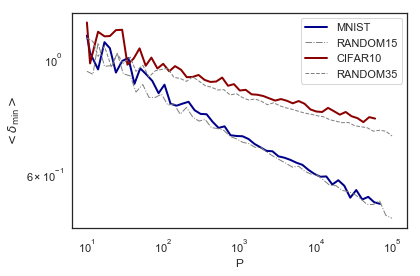

In [96]:
sns.set()
sns.set_style("white")
colors = {'MNIST': 'darkblue', 'CIFAR10': 'darkred', 'RANDOM15': 'gray', 'RANDOM35': 'gray'}
widths = {'MNIST': 2, 'CIFAR10': 2, 'RANDOM15': 1, 'RANDOM35': 1}
lss = {'MNIST': '-', 'CIFAR10': '-', 'RANDOM15': '-.', 'RANDOM35': '--'}


with PdfPages('real_data_vs_random_scaling.pdf') as pdf:
    plt.figure(figsize=(6,4))

    for name in ['MNIST', 'RANDOM15', 'CIFAR10', 'RANDOM35']:
        xs = np.asarray(list(nn_dens[name].keys())).reshape(-1,1)
        ys = np.asarray([ v.mean().item() for v in nn_dens[name].values() ]).reshape(-1,)

        reg = LinearRegression().fit(np.log(xs[35:]), np.log(ys[35:]))
        ys0 = np.exp(reg.intercept_)*np.power(xs[0], reg.coef_)
        #plt.plot(xs, [ np.exp(reg.intercept_)*x**reg.coef_/ys0 for x in xs ], c='gray', lw=1, label=None)
        #plt.plot(xs, ys/ys0, label="${}: \delta \sim P^{{-1/d_\mathrm{{eff}}}},\ d_\mathrm{{eff}}={:.2f}$".format(name, -1/reg.coef_[0]), lw=2)
        plt.plot(xs, ys/ys0, label=name, lw=widths[name], c=colors[name], ls=lss[name])

    plt.legend()
    plt.xlabel("P")
    plt.ylabel("$<\delta_\mathrm{min}>$")
    plt.xscale('log')
    plt.yscale('log')

    plt.tight_layout()
    pdf.savefig()
    plt.show()
    plt.close()